#### Out client is a foreign investor who is willing to open a new luxury restaurant in Rome.

We will address such a business case by discussing the following main drivers:
- average income;
- population;
- transportation.

Since we are interested in investing in a luxury restaurant, we first restrict ourselves to just those "Municipi" that stand out for PCI, that is the per-capita income. Within such boroughs, we consider only neighborhoods having a population density higher than a certain predefined treeshold.  
The bunch of "Zone" resulting from the previous wrangling process is then cleaned out of noise via some clustering algorithm, which is applied to a dataframe containing the venues retrieved via the Foursquare API. A filter is subsequently applied to select the more suitable set of neighborhoods.  
Finally, an analysis of the transportation system is performed in order to determine the optimal "Zona"

We recall that "Municipio" is the Italian for borough, and "Zona" is the Italian of "neighborhood".

Finally, a couple of remarks.  
The analysis that we have conducted is very far from being complete and exhaustive. For instance, the limitations of the Foursquare API had the negative conseguence of restricting the number of venues that we could fetch. Moreover, the information about population and income are not updated, hence they are susceptible to changes that can affect the results (data about PCI are dated 2015). One can clearly overcome such obstacles by appealing to other API and by looking at other economic/financial data, as an example.

# > Setting up the working environment

What follows are the packages/modules that we are going to make use of:

In [1]:
import numpy               as np
import pandas              as pd
import geopandas           as gpd
import matplotlib.pyplot   as plt
import matplotlib.colors   as mcolors
import matplotlib.ticker   as mticker

import folium
import requests

from time                  import sleep
from matplotlib            import cm
from bs4                   import BeautifulSoup
from geopy.geocoders       import Nominatim
from geopy.distance        import geodesic
from sklearn.cluster       import KMeans, DBSCAN
from sklearn.preprocessing import minmax_scale

...while the following function will come in handy later when parsing the "Municipi" names:

In [2]:
def decode_roman_numeral(roman):
    """Calculate the numeric value of a Roman numeral (in capital letters)"""
    trans = {'I': 1, 'V': 5, 'X': 10, 'L': 50, 'C': 100, 'D': 500, 'M': 1000}
    values = [trans[r] for r in roman]
    return sum(
        val if val >= next_val else -val
        for val, next_val in zip(values[:-1], values[1:])
    ) + values[-1]

Finally, we set `pandas` up and we instatiate a `geolocator`:

In [3]:
pd.set_option('display.max_colwidth',100)
geolocator = Nominatim(timeout=None,user_agent="my-application")

Ok, we are ready to go!

# > Preparing the data

First, we import the `shapefile` of all the "Municipi" of Rome.

In [4]:
municipi_shape = gpd.read_file('Municipi_Roma/Municipi_Roma_15_wgs84_1.shp')
municipi_shape = municipi_shape[['municipio', 'geometry']]
municipi_shape.columns = ['Municipio', 'geometry']
municipi_shape['centroid'] = municipi_shape.centroid
municipi_shape

,Municipio,geometry,centroid
0,1,"POLYGON ((12.44396429560499 41.93390563212018, 12.44472860492639 41.93212294554307, 12.445621988...",POINT (12.47794957216206 41.89862783382235)
1,2,"POLYGON ((12.50099009641334 41.94215091200707, 12.50117499673674 41.94199290861449, 12.501209116...",POINT (12.50118015815557 41.92070443930409)
2,3,"POLYGON ((12.56321842936843 42.0746503480542, 12.56270468687821 42.07313227773334, 12.5622352183...",POINT (12.55432440904708 41.99643880815712)
3,4,"POLYGON ((12.63542751558742 41.95729334047995, 12.63697005361801 41.95728267543012, 12.637626071...",POINT (12.59134303179174 41.93216217642325)
4,5,"POLYGON ((12.61538569725759 41.8994678313681, 12.6153026407169 41.8964011602812, 12.615301016170...",POINT (12.5755652813048 41.88910484295808)
5,6,"POLYGON ((12.70671898574038 41.93374960131478, 12.70692466723964 41.93290780851559, 12.707298048...",POINT (12.68711693427256 41.88754992597934)
6,7,"POLYGON ((12.51669097071564 41.89194065206828, 12.5226718221839 41.88879531559317, 12.5226913604...",POINT (12.58189856748587 41.83904194562457)
7,8,"POLYGON ((12.48108711352721 41.87642421858655, 12.48138072806414 41.87575033581445, 12.482238765...",POINT (12.52916829307572 41.8286671861449)
8,9,"POLYGON ((12.47554984763164 41.84734621088112, 12.47616342094209 41.84584423657989, 12.477769214...",POINT (12.4978129603818 41.75764873749063)
9,10,"POLYGON ((12.35255682923618 41.80295244258767, 12.35351599834374 41.80286018465183, 12.354411428...",POINT (12.36309958309614 41.73939020074739)


Next, we download from [Wikipedia](https://it.wikipedia.org/wiki/Municipi_di_Roma) further data about such "Municipi":

In [5]:
municipi_wikitable = BeautifulSoup(requests.get('https://it.wikipedia.org/wiki/Municipi_di_Roma').content, 'html.parser')

municipi_df = []

for item in municipi_wikitable.table.find_all('tr')[1:]:
    data = [td.text.strip() for td in item.findAll('td')]
    municipio = data[0]
    area = data[2]
    municipi_df.append((municipio, area))

municipi_df = pd.DataFrame(municipi_df, columns=['Municipio', 'Area'])
municipi_df.drop([15,16],inplace=True)
municipi_df['Area'] = municipi_df['Area'].str.replace(',','.').astype(float)
municipi_df['Name'] = municipi_df['Municipio'].str.extract(r'^[IVX]+\s{1}(.+)')
municipi_df['Municipio'] = [str(decode_roman_numeral(n)) for n in municipi_df['Municipio'].str.extract(r'^([XVI]+)\s+',expand=False).tolist()]

municipi_df['Latitude'] = municipi_shape.centroid.apply(lambda p: round(p.y,7)).astype(float)
municipi_df['Longitude'] = municipi_shape.centroid.apply(lambda p: round(p.x,7)).astype(float)

cols = municipi_df.columns.tolist()
cols = [cols[0]] + cols[2:] + [cols[1]]
municipi_df = municipi_df[cols]

print("And here we are:")

municipi_df

And here we are:


,Municipio,Name,Latitude,Longitude,Area
0,1,Centro Storico,41.898628,12.477950,19.9
1,2,Parioli/Nomentano,41.920704,12.501180,19.6
2,3,Monte Sacro,41.996439,12.554324,97.8
3,4,Tiburtina,41.932162,12.591343,49.1
4,5,Prenestino/Centocelle,41.889105,12.575565,27.0
5,6,Roma delle Torri,41.887550,12.687117,113.4
6,7,Appio-Latino/Tuscolana/Cinecittà,41.839042,12.581899,46.8
7,8,Appia Antica,41.828667,12.529168,47.3
8,9,Eur,41.757649,12.497813,183.1
9,10,Ostia/Acilia,41.739390,12.363100,150.6


Great!

#### Let's have a look at the map of Rome and its "Municipi"!

In [6]:
rome = geolocator.geocode('Roma, RM, LAZ, Italia')
rome_latitude = rome.latitude
rome_longitude = rome.longitude

print(f"The geographical coordinates of Rome, Italy are {round(rome_latitude,2)}N and {round(rome_longitude,2)}E")

The geographical coordinates of Rome, Italy are 41.89N and 12.49E


In [7]:
rome_map = folium.Map(location=[rome_latitude, rome_longitude], zoom_start=10, tiles='CartoDB positron')

folium.Choropleth(
    geo_data=municipi_shape.drop('centroid',axis=1),
    fill_color='silver', 
    fill_opacity=0.6, 
    line_color='black',
    line_weight=2,
    ).add_to(rome_map)

locations = municipi_df[['Latitude','Longitude']].values
names = municipi_df['Name'].tolist()
nums = municipi_df['Municipio'].tolist()

for loc, num, name in zip(locations, nums, names):
    folium.Marker(loc, popup=folium.Popup('<center><b>Municipio ' + str(num) + '</b></br>' + name + '</center>')
        ).add_to(rome_map)
    
#rome_map.save('roma_and_municipi.html')
rome_map

Nice!!

#### Let's go ahead and load other data!

Namely, the PCI by "Municipio".

_\*note that such an `xls` table has been downloaded from the [official database](https://www.comune.roma.it/web/it/analisi-statistiche.page) of the Municipality of Rome_

In [8]:
income = pd.read_excel('income_by_municipio_2015.xls',
                        sheet_name='Tab_3',
                        header=4,
                        skipfooter=4,
                        dtype=np.float_,
                        usecols=[0,1]).reset_index()
income.columns = ['Municipio', 'Average Income']
income['Municipio'] = [str(decode_roman_numeral(n)) for n in income['Municipio'].str.extract(r'Municipio\s?([XVI]+)', expand=False).tolist()]
income['Average Income'] = income['Average Income'].astype(int)

municipi_df = pd.merge(municipi_df,income,on='Municipio')

municipi_df

,Municipio,Name,Latitude,Longitude,Area,Average Income
0,1,Centro Storico,41.898628,12.477950,19.9,37595
1,2,Parioli/Nomentano,41.920704,12.501180,19.6,40530
2,3,Monte Sacro,41.996439,12.554324,97.8,25379
3,4,Tiburtina,41.932162,12.591343,49.1,21195
4,5,Prenestino/Centocelle,41.889105,12.575565,27.0,18773
5,6,Roma delle Torri,41.887550,12.687117,113.4,17053
6,7,Appio-Latino/Tuscolana/Cinecittà,41.839042,12.581899,46.8,24048
7,8,Appia Antica,41.828667,12.529168,47.3,28007
8,9,Eur,41.757649,12.497813,183.1,29587
9,10,Ostia/Acilia,41.739390,12.363100,150.6,22726


It might be useful to plot the data about average incomes on the previous map: we might get some interesting insights...

In [9]:
rome_pci = folium.Map(location=[rome_latitude, rome_longitude], zoom_start=10, tiles='CartoDB positron') #, tiles='Stamen Toner')

folium.Choropleth(
    geo_data=municipi_shape.drop('centroid',axis=1), #'municipi.geojson',
    data=municipi_df,
    columns=['Municipio','Average Income'],
    key_on='feature.properties.Municipio',
    fill_color='Purples', 
    fill_opacity=0.7, 
    line_opacity=0.5,
    line_weight=1,
    legend_name='Per Capita Income by "Municipio"',
    highlight=True,
    bins=9
    ).add_to(rome_pci)

locations = municipi_df[['Latitude','Longitude']].values
names = municipi_df['Name'].tolist()
nums = municipi_df['Municipio'].tolist()
income = municipi_df['Average Income'].tolist()
popup = '<center><b>Municipio {}</b></br><i>{}</i></br>PCI: {:,} &#8364</center>'
for loc, num, name, pci in zip(locations, nums, names, income):
    folium.Marker(loc, popup=folium.Popup(popup.format(num,name,pci))).add_to(rome_pci)
    
rome_pci

We can now address the **first driver**. In particular, we will try to find an answer for the question:

> _which is the_ wealthiest _"Municipio"?_

To do so, we select those "Municipi" whose PCI is greater than a certain threshold.

In [10]:
municipi_df = municipi_df[(municipi_df['Average Income']>27500)].reset_index(drop=True)
municipi_df

,Municipio,Name,Latitude,Longitude,Area,Average Income
0,1,Centro Storico,41.898628,12.477950,19.9,37595
1,2,Parioli/Nomentano,41.920704,12.501180,19.6,40530
2,8,Appia Antica,41.828667,12.529168,47.3,28007
3,9,Eur,41.757649,12.497813,183.1,29587
4,15,Cassia/Flaminia,42.029723,12.415673,186.7,30290


#### Let's make a step further and import what is necessary to get a better understanding of the neighborhoods subdivision of Rome.  

Thus, we import the `shapefile` of all the "Zone" in Rome...

_\*we remark that such a file has been downloaded from [here](http://mapparoma.blogspot.com/p/zone-urbanistiche.html)._

In [11]:
zone_shape = gpd.read_file('ZU_shapefile/ZU_COD.shp')\
                .drop(['Name', 'TIPZU'], axis=1)\
                .to_crs({'proj': 'latlong'})#, 'ellps': 'WGS84', 'datum': 'WGS84'

zone_shape.columns = ['Zona', 'Code', 'Municipio', 'GRA', 'Area', 'geometry']

zone_shape['Code'] = zone_shape['Code'].apply(lambda c: '0'+c if len(c)==2 else c)
zone_shape['Municipio'] = zone_shape['Municipio'].astype(int)
zone_shape['GRA'] = zone_shape['GRA'].astype(bool)
zone_shape['Area'] = zone_shape['Area'].astype(float)/100
zone_shape['Latitude'] = zone_shape.geometry.centroid.apply(lambda p: round(p.y,10)).astype(float)
zone_shape['Longitude'] = zone_shape.geometry.centroid.apply(lambda p: round(p.x,10)).astype(float)

And we load the `xlsx` table containing info about popolution per neighborhood:

In [12]:
population = pd.read_excel('Tab_3_ZUrb_T1_17.xlsx', skiprows=1, skipfooter=3, usecols="B,J").iloc[1:]
row_to_be_dropped = population[population['Zona urbanistiche Old'].isin(['n.l.', 'Totale municipio'])].index
population = population.drop(row_to_be_dropped.tolist()).reset_index(drop=True)
population.columns = ['Code', 'Population']
population['Population'] = population['Population'].astype(int)

Finally, we merge them!

In [13]:
zone_shape = pd.merge(zone_shape,population,how='left',on='Code')
zone_shape = zone_shape.sort_values(by='Code').reset_index(drop=True)

zone_shape['Density'] = (zone_shape.Population/zone_shape.Area).astype(int)

cols = zone_shape.columns.tolist()
cols = [cols[1],cols[0],cols[2]] + cols[6:8] + [cols[4]] + cols[8:] + [cols[3], cols[5]]
zone_shape = zone_shape[cols]

print('The ultimate table is the following:')

zone_shape.iloc[:,:-1].head(10)

The ultimate table is the following:


,Code,Zona,Municipio,Latitude,Longitude,Area,Population,Density,GRA
0,01A,Centro Storico,1,41.899943,12.477408,3.20,31071,9709,True
1,01B,Trastevere,1,41.890177,12.467300,1.81,17258,9534,True
2,01C,Aventino,1,41.879028,12.484951,1.55,8313,5363,True
3,01D,Testaccio,1,41.877670,12.474642,0.65,8006,12316,True
4,01E,Esquilino,1,41.894942,12.500762,3.08,35671,11581,True
5,01F,XX Settembre,1,41.905828,12.496415,1.41,8977,6366,True
6,01G,Celio,1,41.886515,12.500398,0.67,3945,5888,True
7,01X,Zona Archeologica,1,41.881921,12.493051,1.93,752,389,True
8,02A,Villaggio Olimpico,2,41.931757,12.475473,1.15,2823,2454,True
9,02B,Parioli,2,41.924776,12.483819,2.08,22114,10631,True


Well done!

The data contained in the above table let us address the second driver: **population**.  
In particular, we would like to answer to the question:

> _which "Zona" is sufficiently enough populated?_

Thus, we are going to cut off all those neighborhoods which have a population density below some predefined value.  
Moreover, we assume that our client is merely interested in locations inside the GRA Junction.

In [14]:
mask = (zone_shape.Density>1000) & (zone_shape.GRA==True) & (zone_shape.Municipio.isin(municipi_df.Municipio.tolist()))
zone_df = zone_shape[mask].drop(['GRA'], axis=1).reset_index(drop=True)
zone_df.rename({'Zona':'Name'}, axis=1, inplace=True)

print("Here we are:")

zone_df.iloc[:,:-1]

Here we are:


,Code,Name,Municipio,Latitude,Longitude,Area,Population,Density
0,01A,Centro Storico,1,41.899943,12.477408,3.20,31071,9709
1,01B,Trastevere,1,41.890177,12.467300,1.81,17258,9534
2,01C,Aventino,1,41.879028,12.484951,1.55,8313,5363
3,01D,Testaccio,1,41.877670,12.474642,0.65,8006,12316
4,01E,Esquilino,1,41.894942,12.500762,3.08,35671,11581
5,01F,XX Settembre,1,41.905828,12.496415,1.41,8977,6366
6,01G,Celio,1,41.886515,12.500398,0.67,3945,5888
7,02A,Villaggio Olimpico,2,41.931757,12.475473,1.15,2823,2454
8,02B,Parioli,2,41.924776,12.483819,2.08,22114,10631
9,02C,Flaminio,2,41.924993,12.467214,1.38,13092,9486


# \> Analyzing the data...

To begin with, let's see which "Zona" is within which "Municipio":

In [15]:
zone_in_municipi = zone_df.drop('Code',axis=1).groupby('Municipio').agg(lambda row: ", ".join(row.values))
zone_in_municipi.columns = ['Zone']
zone_in_municipi

,Zone
Municipio,
1,"Centro Storico, Trastevere, Aventino, Testaccio, Esquilino, XX Settembre, Celio, Prati, Della Vi..."
2,"Villaggio Olimpico, Parioli, Flaminio, Salario, Trieste, Nomentano, S. Lorenzo, Universita"
8,"Ostiense, Valco S. Paolo, Garbatella, Navigatori, Tormarancia, Tre Fontane, Grottaperfetta"
9,"Eur, Villaggio Giuliano, Torrino, Laurentino, Cecchignola"
15,"Tor di Quinto, Acquatraversa, Tomba di Nerone, Farnesina"


Well, a map is by far more helpful...

In [16]:
zone_map = folium.Map(location=[rome_latitude, rome_longitude], zoom_start=12, tiles='CartoDB positron') #, tiles='Stamen Toner')

folium.Choropleth(
    geo_data=zone_df,
    data=zone_df,
    columns=['Name','Density'],
    key_on='feature.properties.Name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.5,
    line_weight=1,
    legend_name='Density by "Zona" (thousands)',
    highlight=True,
    bins=9
    ).add_to(zone_map)

locations = zone_df[['Latitude','Longitude']].values
names = zone_df['Name'].tolist()
codes = zone_df['Code'].tolist()
densities = zone_df['Density'].tolist()
popup = '<center><b>Zona {}</b></br><i>{}</i></br>inhabitants per km2: {:,}</center>'
for loc, name, code, density in zip(locations, names, codes, densities):
    folium.map.Marker(loc, popup=folium.Popup(popup.format(code,name,density))).add_to(zone_map)
    
#zone_map.save('rome_and_zone.html')
zone_map

We can now go ahead with the analysis and clean data out of noise.   
The algorithm will run on the number and the category of nearby venues.

#### Step 1: get the venues!

To do so, we are going to make use of the _Foursquare_ API.

In [17]:
CLIENT_ID = '***' # hidden for security reasons
CLIENT_SECRET = '***' # hidden for security reasons
API_VERSION = '20180605'

It might be a good idea to find the optimal radius that results in the largest number of venues returned by _Foursquare_.

Hence, let's compute di minimum distance among the "Municipi" centroids!

In [18]:
tmp = list(map(tuple, locations))
dist = []
for i in range(len(locations)):
    for j in range(i+1,len(locations)):
        dist.append(geodesic(tmp[i],tmp[j]).meters)
dist = int(sorted(dist)[0])+1

print(f"The optimal choice for the radius is {dist} meters.")

The optimal choice for the radius is 777 meters.


Good to know!  

The following function will let us get as much venues as possibile (well, up to 200 actually!):

In [19]:
def getNearbyVenuesOf(df):
    
    LIMIT = 100
    RADIUS = dist
    CATEGORIES = ['food', 'drinks', 'coffee', 'shops', 'sights', 'arts', 'outdoors'] 
    
    names = df['Name'].tolist()
    codes = df['Code'].tolist()
    municipis = df['Municipio'].tolist()
    latitudes = df['Latitude'].tolist()
    longitudes = df['Longitude'].tolist()
    
    venues_list=[] 
    
    for name, code, municipio, lat, lng in zip(names, codes, municipis, latitudes, longitudes):
        
        for category in CATEGORIES:           
            for k in range(2):
                
                url = '''https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}
                            &ll={},{}
                            &radius={}
                            &limit={}
                            &offset={}
                            &section={}'''\
                      .format(
                            CLIENT_ID, 
                            CLIENT_SECRET, 
                            API_VERSION, 
                            lat, 
                            lng, 
                            RADIUS, 
                            LIMIT,
                            k*LIMIT,
                            category)#LIMIT)

                results = requests.get(url).json()
                
                if results['meta']['code'] == 200:
                    results = results["response"]['groups'][0]['items']
                    venues_list.append([(
                        name,
                        code,
                        municipio,
                        lat, 
                        lng,  
                        v['venue']['name'], 
                        v['venue']['id'],
                        v['venue']['location']['lat'], 
                        v['venue']['location']['lng'],  
                        v['venue']['categories'][0]['name']) for v in results])
                
                sleep(1)

    venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    venues.columns = ['Zona',
                      'Code',
                      'Municipio',
                      'Latitude', 
                      'Longitude', 
                      'Venue',  
                      'Venue ID', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category']
    
    return(venues)

In [20]:
foursquare_venues = getNearbyVenuesOf(zone_df)

In [21]:
print(f"The number of venues returned by 'Foursquare' is {len(foursquare_venues)}.")

The number of venues returned by 'Foursquare' is 3228.


Since there might be some duplicates, let's take care of them!


In [22]:
foursquare_venues = foursquare_venues.drop_duplicates('Venue', keep='first').reset_index(drop=True)
#foursquare_venues.to_csv('foursquare_venues_unique.csv')
print(f"The number of distinct venues returned by 'Foursquare' is {len(foursquare_venues)}.")
print("The following is a sample of the above venues:")
foursquare_venues.sample(20).sort_index()

The number of distinct venues returned by 'Foursquare' is 1967.
The following is a sample of the above venues:


,Zona,Code,Municipio,Latitude,Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
167,Centro Storico,01A,1,41.899943,12.477408,Bialetti,544e5fef498ea8553f404a69,41.901126,12.480911,Furniture / Home Store
427,Trastevere,01B,1,41.890177,12.467300,Tanto Era Tanto Antico,4bc76c3214d795214e5b67e9,41.887210,12.469546,Wine Bar
517,Aventino,01C,1,41.879028,12.484951,Roma Beer Company - Piramide Cestia,533e58d511d2d4a3b8bc8235,41.878173,12.482404,Brewery
560,Testaccio,01D,1,41.877670,12.474642,Masto,58adece7ac329162f04cda67,41.877873,12.477364,Wine Bar
596,Testaccio,01D,1,41.877670,12.474642,Teatro Cometa Off,4c0bc660340720a1f58f8893,41.880259,12.477032,Theater
806,XX Settembre,01F,1,41.905828,12.496415,Bufala e Pachino,4ee211dd29c20563bb997d33,41.902416,12.494088,Fast Food Restaurant
867,XX Settembre,01F,1,41.905828,12.496415,Fontana delle Naiadi,4c7ce6fa7a856dcbfe53e3a7,41.902594,12.496390,Fountain
872,XX Settembre,01F,1,41.905828,12.496415,Dal Sorchettaro,4c9d46ef7c096dcbcdbec9d1,41.907038,12.500917,Dessert Shop
888,Celio,01G,1,41.886515,12.500398,Naumachia,4beef98a6faac9b6899fa9c6,41.889120,12.496680,Italian Restaurant
891,Celio,01G,1,41.886515,12.500398,I Clementini,4b86ec2df964a52015a631e3,41.889110,12.497466,Italian Restaurant


The number of distinct venues returned per 'Municipio' is plotted in following chart:


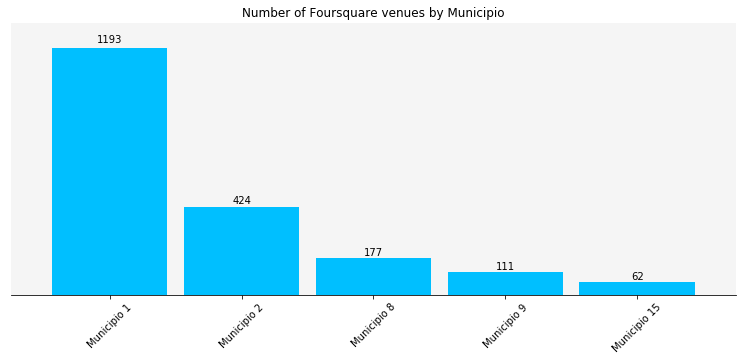

In [23]:
venues_count = foursquare_venues.groupby('Municipio').count()
venues_count.drop([col for col in venues_count.columns if col!='Venue'], axis=1, inplace=True)
venues_count.columns = ['Number of venues']

fig, ax = plt.subplots()
fig.set_size_inches(13,5)
ax.set_title('Number of Foursquare venues by Municipio')
ax.set_facecolor('whitesmoke')
x = venues_count.index.tolist()
y = venues_count['Number of venues'].tolist()
ticks = np.arange(len(venues_count))
width = 0.5
bars = ax.bar(ticks+width/2, y, 1.75*width, color='deepskyblue')
ax.set_xlim([-width,len(venues_count)])
ax.set_ylim([0,1.1*max(y)])
ax.set_xticks(ticks + width/2)
ax.set_yticks([])
ax.set_xticklabels([f"Municipio {m}" for m in venues_count.index.tolist()], rotation = 45, ha="center")
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

for b in bars:
    height = b.get_height()
    ax.text(b.get_x() + b.get_width()/2, 1.01*height, '{}'.format(height), ha='center', va='bottom')

print("The number of distinct venues returned per 'Municipio' is plotted in following chart:")

plt.show()

#print("and it is represented by the following table:")
#venues_count.sort_values('Number of venues', ascending=False)

So far, so good.

#### Step 2: clustering!

Before moving on, a consideration is in order:  
Opera Houses, Concert Halls and Theaters are generally recognized as venues attended by somewhat aristocratic/wealthy people.  
Based on such a thought, and supposing that a certain percentage of such people might want to go out for dinner before/after a concert/play, we will drop all such venues before runnung any Machine Learning algorithm. We will make use of them later as a filter to select the optimal neighborhood.

In [24]:
mask = (foursquare_venues['Venue Category'].str.contains('Opera'))|\
       (foursquare_venues['Venue Category'].str.contains('Concert'))|\
       (foursquare_venues['Venue Category'].str.contains('^Theater$',regex=True))  

In [25]:
train_venues = foursquare_venues[~mask]
print('And here we are:')
train_venues.sample(20).sort_index()

And here we are:


,Zona,Code,Municipio,Latitude,Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
12,Centro Storico,01A,1,41.899943,12.477408,Casa Coppelle,4c0fedc1f1b6a593f1137b27,41.900849,12.475977,Roman Restaurant
234,Centro Storico,01A,1,41.899943,12.477408,Piazza della Minerva,4cbdbc677148f04db9aeeeab,41.897913,12.477421,Plaza
435,Trastevere,01B,1,41.890177,12.467300,Bar Picchioti,4e1c97f9185089860b1da334,41.887335,12.469112,Café
560,Testaccio,01D,1,41.877670,12.474642,Masto,58adece7ac329162f04cda67,41.877873,12.477364,Wine Bar
613,Esquilino,01E,1,41.894942,12.500762,Caronte,4fac3d2ce4b03d702f50994d,41.892508,12.503160,Restaurant
641,Esquilino,01E,1,41.894942,12.500762,Miky Bar,4d6936376297721e1abac5b5,41.896031,12.504932,Café
673,Esquilino,01E,1,41.894942,12.500762,Big Ben A Santa Maria Maggiore,5029604fe4b09b8b68a62107,41.897796,12.497364,Café
734,XX Settembre,01F,1,41.905828,12.496415,Da Vincenzo,4adcdacff964a520ac5521e3,41.907665,12.499468,Seafood Restaurant
846,XX Settembre,01F,1,41.905828,12.496415,Farmacia Altesi,4e6f761a7d8bbeefd9df3d02,41.907987,12.499250,Pharmacy
1022,Flaminio,02C,2,41.924993,12.467214,Fu Hao,4e2f2855149532963301b66a,41.926863,12.463750,Chinese Restaurant


The _one-hot encoding_ is a good preprocessing technique.

In [26]:
venues_onehot = pd.get_dummies(train_venues[['Venue Category']], prefix="", prefix_sep="")
venues_onehot['Name'] = foursquare_venues['Zona'] 
venues_onehot['Municipio'] = foursquare_venues['Municipio'] 

cols = venues_onehot.columns
cols = list(cols[-2:]) + list(cols[:-2])

venues_onehot = venues_onehot[cols]

We need to group all the venues by zone and take the average.  

In [27]:
grouped_venues = venues_onehot.drop('Municipio',axis=1).groupby('Name').mean().reset_index()

Perfect!  
#### We now run a clustering algorithm to clean up the above table.
Namely, we are going to detect the core cluster, while in the meantime we flag as outliers those neighborhoods that do not fit in it.

In [28]:
dbscan = DBSCAN(eps=1, min_samples=5, metric='cityblock').fit(grouped_venues.drop('Name', axis=1))
grouped_venues['Outlier?'] = np.array(dbscan.labels_,dtype=bool)

cols = grouped_venues.columns.tolist()
cols = [cols[0], cols[-1]] + cols[1:-1]
grouped_venues = grouped_venues[cols]

zone_clusters = grouped_venues[['Name', 'Outlier?']]
zone_clusters

,Name,Outlier?
0,Acquatraversa,True
1,Aventino,False
2,Cecchignola,True
3,Celio,False
4,Centro Storico,False
5,Della Vittoria,True
6,Eroi,False
7,Esquilino,False
8,Eur,True
9,Farnesina,True


#### Let's have a look at the map!

In [29]:
zone_data = pd.merge(grouped_venues,zone_df, how='left', on='Name')

clusters_map = folium.Map(location=[rome_latitude, rome_longitude], zoom_start=12, tiles='CartoDB positron')

folium.Choropleth(
    geo_data=zone_df,
    fill_opacity=0.0, 
    line_color='black',
    line_weight=3,
    ).add_to(clusters_map)

for lat, lon, poi, outlier in zip(zone_data['Latitude'], zone_data['Longitude'], zone_data['Name'], zone_data['Outlier?']):
    label = folium.Popup("<center>" + str(poi) + "</br><b>{}</b></center>".format('outlier!' if outlier else 'not an outlier'))
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color= 'darkorange' if outlier else 'dodgerblue',#cmap_bord[cluster-1],
        fill=True,
        fill_color='yellow' if outlier else 'cyan',#cmap_fill[cluster-1],
        fill_opacity=1).add_to(clusters_map)
       
clusters_map

#### Step 3: analyze the core cluster!

To begin with, let's drop all the ouliers.

In [30]:
code = zone_data[['Code','Name','Area']]
zone_clusters = pd.merge(zone_clusters,code,how='left', on='Name')

cols = zone_clusters.columns.tolist()
cols = [cols[0],cols[2],cols[3], cols[1]]
zone_clusters = zone_clusters[cols]

zone_clusters = zone_clusters[~zone_clusters['Outlier?']].reset_index(drop=True).drop('Outlier?',axis=1)
zone_clusters[['Name', 'Code']]

,Name,Code
0,Aventino,01C
1,Celio,01G
2,Centro Storico,01A
3,Eroi,17C
4,Esquilino,01E
5,Parioli,02B
6,Prati,17A
7,S. Lorenzo,03B
8,Salario,02D
9,Trastevere,01B


Now, we plug into the equation all those venues labelled as 'Opera House', 'Concert Hall', and 'Theater'.  

_\*note that from now on we will simply refer to any of 'Opera House' and 'Concert Hall' and 'Theater' as 'Theater'._

In [31]:
theaters = foursquare_venues[mask][['Code','Venue']].reset_index(drop=True)
theaters.columns = ['Code', 'Theater']
theaters = theaters.groupby('Code',as_index=False).count()
theaters = pd.merge(zone_clusters,theaters,how='left',on='Code').merge(zone_df[['Code']],how='left',on='Code').fillna('0')
theaters.columns = ['Name', 'Code', 'Area', 'Theaters']
theaters['Theaters'] = theaters.Theaters.astype(int)
theaters['Theaters per km2'] = (theaters.Theaters/theaters.Area).apply(lambda x: round(x,2))

The following chart shows how theaters are distribuited among the selected neighborhoods.
The size of the bubbles represents the area in km2.




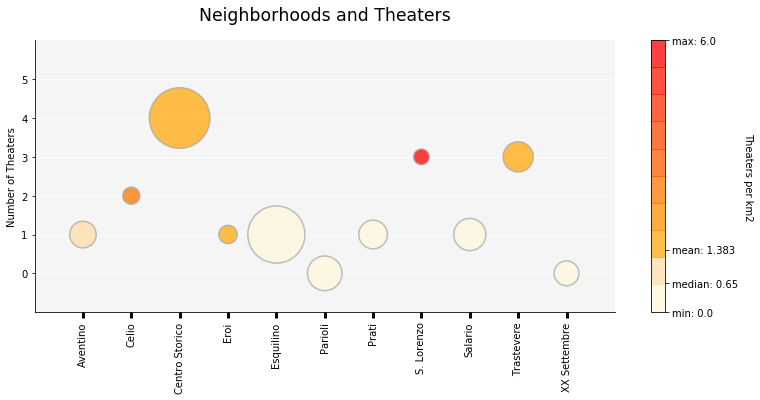

And this is the table of contained the above data:


,Name,Code,Area,Theaters,Theaters per km2
7,S. Lorenzo,03B,0.50,3,6.00
1,Celio,01G,0.67,2,2.99
9,Trastevere,01B,1.81,3,1.66
2,Centro Storico,01A,3.20,4,1.25
3,Eroi,17C,0.81,1,1.23
0,Aventino,01C,1.55,1,0.65
6,Prati,17A,1.70,1,0.59
8,Salario,02D,1.93,1,0.52
4,Esquilino,01E,3.08,1,0.32
5,Parioli,02B,2.08,0,0.00


In [32]:
fig,ax = plt.subplots()
fig.set_size_inches(13,5)
ax.set_title('Neighborhoods and Theaters', pad=20, fontsize='xx-large', fontweight='medium')
ax.set_facecolor('whitesmoke')
tmp = theaters.sort_values('Name')
x = tmp.Name.tolist()
y = tmp.Theaters.tolist()
z = np.exp(tmp.Area.values)
l = minmax_scale(tmp['Theaters per km2'].tolist())
gradient = minmax_scale(tmp['Theaters per km2'].values)
c = [[np.min(gradient), "cornsilk"], [np.median(gradient), "navajowhite"], [np.mean(gradient), "orange"], [np.max(gradient), "red"]]
myYlOrRd = mcolors.LinearSegmentedColormap.from_list('myYlOrRd', c, N=len(tmp['Theaters per km2'].unique()))
bubbles = ax.scatter(x, y, s=150*z, c=l, cmap=myYlOrRd, alpha=0.75, edgecolors="darkgray", linewidth=1.5, zorder=1000)
ticks = np.arange(len(venues_count))
width = 0.5
ax.set_xlim([-1,len(x)])
ax.set_ylim([-1,1.5*max(y)])
ax.xaxis.set_ticks(np.arange(0,len(x),1))
ax.xaxis.set_tick_params(which='major',width=3, length=6, rotation=90)
ax.yaxis.grid(which='both',color='white')
ax.yaxis.set_major_locator(mticker.FixedLocator(list(range(0,6))))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
ax.set_ylabel('Number of Theaters')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ticks = [np.min(tmp['Theaters per km2']), np.median(tmp['Theaters per km2']), np.mean(tmp['Theaters per km2']), np.max(tmp['Theaters per km2'])]
cbar = fig.colorbar(bubbles, ticks=minmax_scale(ticks), alpha=0.5)
cbar.ax.set_yticklabels([f"min: {ticks[0]}", f"median: {round(ticks[1],3)}", f"mean: {round(ticks[2],3)}", f"max: {ticks[3]}"])
cbar.set_label('Theaters per km2', rotation=270, labelpad=15)

print("The following chart shows how theaters are distribuited among the selected neighborhoods.")
print("The size of the bubbles represents the area in km2.")
print("\n")

plt.show()

print("And this is the table of contained the above data:")

theaters.sort_values('Theaters per km2', ascending=False)

Since we have decided to take under consideration the presence of Opera Houses, Concert Hall and Theaters in the candidate neighborhoods, we drop the "Zone" where there are no such venues according to Foursquare.

In [33]:
candidate_zones = theaters[theaters.Theaters>0].loc[:,'Code'].tolist()
print("Namely, we will just take under consideration the following neighborhoods:")
print(", ".join(candidate_zones))

Namely, we will just take under consideration the following neighborhoods:
01C, 01G, 01A, 17C, 01E, 17A, 03B, 02D, 01B


In [34]:
candidate_df = pd.merge(theaters.drop('Name',axis=1),\
                        zone_df[zone_df.Code.isin(candidate_zones)][['Code','Name','Latitude','Longitude']].groupby('Code',as_index=False).first(),\
                        how='right',\
                        on='Code')

cols = candidate_df.columns.tolist()
cols = [cols[4], cols[0]] + cols[-2:] + cols[1:4]
candidate_df = candidate_df[cols].sort_values('Name').reset_index(drop=True)

print("Thus, we end up with the following table:")

candidate_df

Thus, we end up with the following table:


,Name,Code,Latitude,Longitude,Area,Theaters,Theaters per km2
0,Aventino,01C,41.879028,12.484951,1.55,1,0.65
1,Celio,01G,41.886515,12.500398,0.67,2,2.99
2,Centro Storico,01A,41.899943,12.477408,3.20,4,1.25
3,Eroi,17C,41.908360,12.448479,0.81,1,1.23
4,Esquilino,01E,41.894942,12.500762,3.08,1,0.32
5,Prati,17A,41.906900,12.464635,1.70,1,0.59
6,S. Lorenzo,03B,41.897870,12.515229,0.50,3,6.00
7,Salario,02D,41.917234,12.500177,1.93,1,0.52
8,Trastevere,01B,41.890177,12.467300,1.81,3,1.66


Great!

#### Let's now assess the number of competitors for each neighborhood!

To begin with, we drop all the venues outside the chosen zones...

In [35]:
venues_in_candidate_zones = foursquare_venues[foursquare_venues.Code.isin(candidate_zones)]
print(f"We are left with {len(venues_in_candidate_zones)} venues!")
print("The following are some of them:")
venues_in_candidate_zones.sample(20).sort_index()

We are left with 1112 venues!
The following are some of them:


,Zona,Code,Municipio,Latitude,Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
32,Centro Storico,01A,1,41.899943,12.477408,Sapore di Mare,51476e73e4b0702d38c76718,41.897371,12.478758,Seafood Restaurant
59,Centro Storico,01A,1,41.899943,12.477408,Angelina a Trevi,4d455cb2c3e5f04dfe08a420,41.901190,12.482810,Italian Restaurant
68,Centro Storico,01A,1,41.899943,12.477408,Bar Gambero,4e5e0cb37d8b67dc8fedec3f,41.903433,12.480198,Snack Place
137,Centro Storico,01A,1,41.899943,12.477408,Non Solo Bevi,4bf28dffa32e20a11e52d557,41.899989,12.479622,Café
154,Centro Storico,01A,1,41.899943,12.477408,Lindt,51eaac8b498e9caed1d195d1,41.900225,12.476590,Chocolate Shop
155,Centro Storico,01A,1,41.899943,12.477408,Zara,4d022f6057e2a0935479d436,41.901667,12.480357,Clothing Store
171,Centro Storico,01A,1,41.899943,12.477408,United Colors Of Benetton,50d2ca87e4b0e638bc4a0711,41.897937,12.474086,Clothing Store
200,Centro Storico,01A,1,41.899943,12.477408,Il Papiro,4d4ed1655fb0b1f750d47e91,41.899529,12.476653,Paper / Office Supplies Store
297,Centro Storico,01A,1,41.899943,12.477408,Piazza Dell' Oratorio,4e2994b2c65ba11f4c67ed39,41.899514,12.482166,Plaza
449,Trastevere,01B,1,41.890177,12.467300,Todis,55d978c1498e86c4d77ffeea,41.887145,12.469741,Supermarket


Clearly, we would like to select a neighborhood that does not count not many restaurants...  

_\*recall that we are not considering restaurants that are proposing special/local menus!_

In [36]:
restaurant_category = ['Trattoria/Osteria', 'Italian Restaurant', 'Restaurant', 'Bistro']
restaurants = venues_in_candidate_zones[venues_in_candidate_zones['Venue Category'].isin(restaurant_category)]

print(f"It seems like there are about {len(restaurants)} restaurants in those neighborhoods...\n")
print("Grouping them by 'Zona', and considering the density per km2, yields:")

restaurants = restaurants[['Code','Venue Category']].groupby('Code',as_index=False).count().sort_values(by='Venue Category', ascending=False)
restaurants.rename(columns={'Venue Category':'Restaurants'}, inplace=True)

candidate_df = pd.merge(candidate_df,restaurants,how='left',on='Code')
candidate_df['Restaurants per km2'] = (candidate_df.Restaurants/candidate_df.Area).apply(lambda x: round(x,2))

It seems like there are about 249 restaurants in those neighborhoods...

Grouping them by 'Zona', and considering the density per km2, yields:


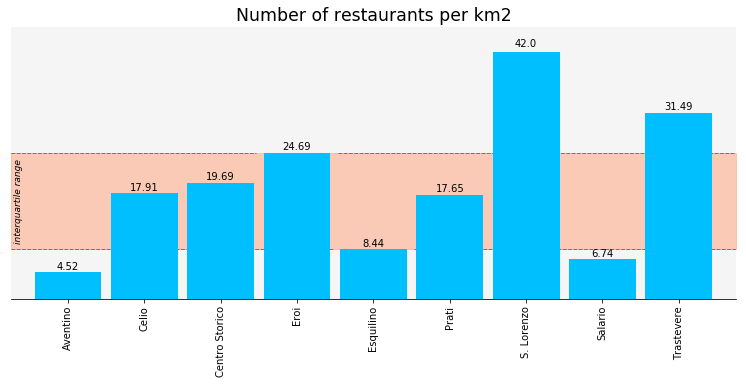

,Name,Code,Latitude,Longitude,Area,Theaters,Theaters per km2,Restaurants,Restaurants per km2
0,Aventino,01C,41.879028,12.484951,1.55,1,0.65,7,4.52
1,Celio,01G,41.886515,12.500398,0.67,2,2.99,12,17.91
2,Centro Storico,01A,41.899943,12.477408,3.20,4,1.25,63,19.69
3,Eroi,17C,41.908360,12.448479,0.81,1,1.23,20,24.69
4,Esquilino,01E,41.894942,12.500762,3.08,1,0.32,26,8.44
5,Prati,17A,41.906900,12.464635,1.70,1,0.59,30,17.65
6,S. Lorenzo,03B,41.897870,12.515229,0.50,3,6.00,21,42.00
7,Salario,02D,41.917234,12.500177,1.93,1,0.52,13,6.74
8,Trastevere,01B,41.890177,12.467300,1.81,3,1.66,57,31.49


In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(13,5)
ax.set_title('Number of restaurants per km2', fontsize='xx-large', fontweight='medium')
ax.set_facecolor('whitesmoke')
x = candidate_df.Name.values
y = candidate_df['Restaurants per km2'].values
ticks = np.arange(len(x))
width = 0.5
bars = ax.bar(ticks+width/2, y, 1.75*width, color='deepskyblue')
ax.set_xlim([-width,len(x)])
ax.set_ylim([0,1.1*max(y)])
ax.set_xticks(ticks + width/2)
ax.set_yticks([])
ax.set_xticklabels(x, rotation=90, ha="center")
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
    
for b in bars:
    height = b.get_height()
    ax.text(b.get_x()+b.get_width()/2, 1.01*height, '{}'.format(height), ha='center', va='bottom')
        
figx = plt.xlim()
plt.hlines(y=8.44,xmin=figx[0],xmax=3.7375,color='orangered',linewidth=1, linestyles='dashed', zorder=0)
plt.hlines(y=8.44,xmin=4.7875,xmax=figx[1],color='orangered',linewidth=1, linestyles='dashed', zorder=0)
plt.hlines(y=24.69,xmin=figx[0],xmax=2.7125,color='orangered',linewidth=1, linestyles='dashed', zorder=0)
plt.hlines(y=24.69,xmin=3.7875,xmax=figx[1],color='orangered',linewidth=1, linestyles='dashed', zorder=0)
plt.fill_between(figx,y1=8.44,y2=24.69,color='lightsalmon',alpha=0.5,zorder=-1)
ax.text(figx[0]+0.1,16.565, 'interquartile range', fontsize=9, fontstyle='italic', ha='center', va='center', rotation=90, zorder=10)

plt.show()

candidate_df

Perfect!

We can now consider the last driver: **transportation**.
Namely, we are going to address the following questions:
> _which neighborhood is better connected?_ 


> _How easy is to get there via bus/metro/tram?_


> _Is there any parking there?_


Let's get started!

In [38]:
def getPublicTransportationIn(df):
    
    LIMIT = 100
    RADIUS = 500
    CATEGORIES = {'Bus Stop':'52f2ab2ebcbc57f1066b8b4f',
                  'Metro Station':'4bf58dd8d48988d1fd931735',
                  'Tram Station': '52f2ab2ebcbc57f1066b8b51',
                  'Parking': '4c38df4de52ce0d596b336e1'
                 }
    
    codes = df['Code'].tolist()
    latitudes = df['Latitude'].tolist()
    longitudes = df['Longitude'].tolist()
    
    venues_list=[] 
    
    for code, lat, lng in zip(codes, latitudes, longitudes):
        for category_name,category_id in CATEGORIES.items(): 

            url = '''https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}
                        &ll={},{}
                        &categoryId={}
                        &radius={}
                        &limit={}'''\
                .format(CLIENT_ID, CLIENT_SECRET, VERSION,
                        lat, lng, 
                        category_id,
                        RADIUS,
                        LIMIT)
         
            results = requests.get(url).json()["response"]['venues']
            
            venues_list.append([(
                code,
                category_name,
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['location']['distance']) for v in results])

            sleep(1)

    venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    venues.columns = ['Code','Category','Type','Latitude','Longitude','Distance']
    
    return(venues)

In [39]:
tpl = getPublicTransportationIn(candidate_df)
tpl.sample(20).sort_index()

,Code,Category,Type,Latitude,Longitude,Distance
2,01C,Metro Station,Metro Circo Massimo (MB),41.883413,12.488183,556
3,01C,Metro Station,Roma Porta San Paolo (Roma-Lido),41.874830,12.482054,525
9,01A,Bus Stop,Fermata Senato,41.900280,12.473859,296
10,01A,Bus Stop,Fermata ATAC 77307 Corso (Minghetti),41.899362,12.481045,308
12,01A,Bus Stop,Lgt Marzio,41.903079,12.473793,459
13,01A,Bus Stop,S.Claudio Bus Station,41.902070,12.481438,409
15,01A,Bus Stop,ATAC 81964 - Plebiscito,41.896410,12.480990,492
23,17C,Parking,Parcheggio Metro Cipro,41.907033,12.447782,158
24,17C,Parking,Garage Salvatori,41.909990,12.445409,312
28,01E,Bus Stop,Piazza Vittorio Emanuele,41.895818,12.504538,327


Aware of how frequent traffic jams are in Rome, it is obvious that metro stations have a far greater impact on the choice of the optimal neighborhood for our client. As a conseguence, we are going to weight a metro/tram station more (hence, _less_), than a bus stop!

In [41]:
bus_stops = tpl[tpl['Category']=='Bus Stop'].groupby('Code',as_index=False).agg({'Type':'count', 'Distance':'median'})
metro_stations = tpl[tpl['Category']=='Metro Station'].groupby('Code',as_index=False).agg({'Type':'count', 'Distance':'median'})
tram_stations = tpl[tpl['Category']=='Tram Station'].groupby('Code',as_index=False).agg({'Type':'count', 'Distance':'median'})
parking = tpl[tpl['Category']=='Parking'].groupby('Code',as_index=False).agg({'Type':'count', 'Distance':'median'})

bus_stops.rename(columns={'Type':'Bus Stops', 'Distance':'Average Distance from a Bus Stop'}, inplace=True)
metro_stations.rename(columns={'Type':'Metro Stations', 'Distance':'Average Distance from a Metro Station'}, inplace=True)
tram_stations.rename(columns={'Type':'Tram Stations', 'Distance':'Average Distance from a Tram Station'}, inplace=True)
parking.rename(columns={'Type':'Parking', 'Distance':'Average Distance from a parking'}, inplace=True)

zone_tpl = pd.merge(\
            pd.merge(bus_stops,metro_stations,how='left',on='Code').fillna(0),\
            pd.merge(tram_stations,parking,how='left',on='Code').fillna(0),\
           how='left',on='Code').fillna(0)

print("Ok, these are all the data that we might need:")

zone_tpl

Ok, these are all the data that we might need:


,Code,Bus Stops,Average Distance from a Bus Stop,Metro Stations,Average Distance from a Metro Station,Tram Stations,Average Distance from a Tram Station,Parking,Average Distance from a parking
0,01A,8,430.5,0.0,0.0,0.0,0.0,0.0,0.0
1,01B,2,478.5,0.0,0.0,0.0,0.0,0.0,0.0
2,01C,1,507.0,3.0,525.0,1.0,358.0,2.0,523.5
3,01E,7,398.0,2.0,402.0,1.0,224.0,3.0,498.0
4,02D,1,664.0,0.0,0.0,1.0,498.0,6.0,529.0
5,17A,4,376.0,3.0,601.0,1.0,525.0,4.0,276.5
6,17C,1,157.0,1.0,123.0,0.0,0.0,0.0,0.0


Let's process them!

_Note that we are going to call_ "TPL" _the column counting the number of bus stops together with the number of metro stations, which is the Italian for "Local Public Transportation System"._  
_Note also that we are assuming that the weights used in the following are the results of a certain investigation that has been earlier conducted. We may also suppose that they are somewhat based on client's preferences._

In [42]:
zone_tpl['TPL'] = (zone_tpl['Bus Stops']+zone_tpl['Metro Stations']+zone_tpl['Tram Stations']).astype(int)

def averageDistance(row):
    factors = [row['Average Distance from a Bus Stop'],
              row['Average Distance from a Metro Station'],
              row['Average Distance from a Tram Station'],
              row['Average Distance from a parking']]
    
    weights = [1.25*row['Bus Stops'], 0.75*row['Metro Stations'], 1.0*row['Tram Stations'], 1.0*row['Parking']]
    
    cumadd = lambda x,y: x+y
    
    from functools import reduce
    
    weights_sum = reduce(cumadd,weights);
    
    return reduce(cumadd, [w*f for w,f in zip(weights,factors)])/weights_sum if weights_sum!=0 else 0


zone_tpl['Average Distance'] = zone_tpl.apply(averageDistance,axis=1).apply(lambda d: round(d,1))

tpl_df = zone_tpl[['Code','TPL','Average Distance']]

tpl_df

,Code,TPL,Average Distance
0,01A,8,430.5
1,01B,2,478.5
2,01C,5,495.4
3,01E,10,407.3
4,02D,2,545.7
5,17A,8,397.0
6,17C,2,144.2


In [43]:
candidate_df = pd.merge(candidate_df,tpl_df,how='left',on='Code').fillna(0)

candidate_df['TPL'] = candidate_df.TPL.astype(int)
candidate_df['TPL per km2'] = (candidate_df.TPL/candidate_df.Area).apply(lambda x: round(x,2))

The chart below shows the most relevant information about the transportation system for each "Zona".
The size of the bubbles represents the number of nearby TPL.




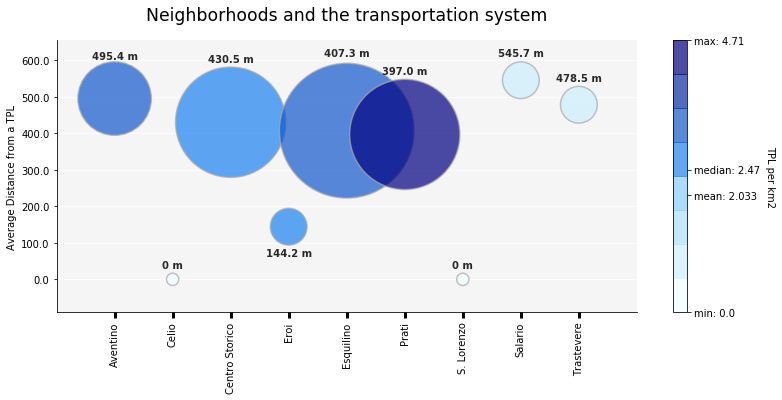

It is based on the following table:


,Name,TPL,Average Distance,TPL per km2
0,Prati,8,397.0,4.71
1,Esquilino,10,407.3,3.25
2,Aventino,5,495.4,3.23
3,Centro Storico,8,430.5,2.50
4,Eroi,2,144.2,2.47
5,Trastevere,2,478.5,1.10
6,Salario,2,545.7,1.04
7,Celio,0,0.0,0.00
8,S. Lorenzo,0,0.0,0.00


In [44]:
plot_df = candidate_df.copy(deep=True)

fig,ax = plt.subplots()
fig.set_size_inches(13,5)
ax.set_title('Neighborhoods and the transportation system', pad=20, fontsize='xx-large', fontweight='medium')
ax.set_facecolor('whitesmoke')
x = plot_df.Name.tolist()
y = plot_df['Average Distance'].tolist()
z = 150*np.power(np.array(plot_df.TPL.tolist())+1,2)
tpl = plot_df['TPL per km2']
l = minmax_scale(tpl.tolist())
gradient = minmax_scale(tpl.values)
m1 = min(np.median(gradient), np.mean(gradient))
m2 = max(np.median(gradient), np.mean(gradient))
c = sorted([[np.min(gradient), "azure"], [m1, "lightskyblue"], [m2, "dodgerblue"], [np.max(gradient), "navy"]], key=lambda item: item[0])
myBlues = mcolors.LinearSegmentedColormap.from_list('myYlOrRd', c, N=len(tpl.unique()))
bubbles = ax.scatter(x, y, s=z, c=l, cmap=myBlues, alpha=0.7, edgecolors="darkgray", linewidth=1.5, zorder=1000)
width = 0.5
ax.set_xlim([-1,len(x)])
ax.set_ylim([-90,1.2*max(y)])
ax.xaxis.set_ticks(np.arange(len(x)))
ax.xaxis.set_tick_params(which='major',width=3, length=6, rotation=90)
ax.yaxis.grid(which='both',color='white')
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
ax.set_ylabel('Average Distance from a TPL')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ticks = [np.min(tpl), np.median(tpl), np.mean(tpl), np.max(tpl)]
cbar = fig.colorbar(bubbles, ticks=minmax_scale(ticks), alpha=0.5)
cbar.ax.set_yticklabels([f"min: {ticks[0]}", f"median: {round(ticks[1],3)}", f"mean: {round(ticks[2],3)}", f"max: {ticks[3]}"])
cbar.set_label('TPL per km2', rotation=270, labelpad=15)

radius = 2*np.sqrt(bubbles.get_sizes())
for i in range(len(x)):
    clus = x[i]
    dist = y[i]
    color = (40/255,40/255,40/255)
    if dist>150:
        if tpl.iloc[i]>ticks[2]:
            ax.text(clus, dist+0.79*radius[i], '{0:.1f} m'.format(dist), color=color, ha='center', va='center', fontweight='semibold', zorder=2000) 
        else:
            ax.text(clus, dist+radius[i], '{0:.1f} m'.format(dist), color=color, ha='center', va='center', fontweight='semibold', zorder=2000)
    elif dist>100 :
        ax.text(clus, dist-radius[i], '{0:.1f} m'.format(dist), color=color, ha='center', va='center', fontweight='semibold', zorder=2000)
    else:
        ax.text(clus, dist+radius[i], '{} m'.format(int(dist)), color=color, ha='center', va='bottom', fontweight='semibold', zorder=2000)
    
print('The chart below shows the most relevant information about the transportation system for each "Zona".')
print("The size of the bubbles represents the number of nearby TPL.")
print("\n")

plt.show()

print("It is based on the following table:")

plot_df[['Name', 'TPL', 'Average Distance', 'TPL per km2']].sort_values('TPL per km2', ascending=False).reset_index(drop=True)

Ok, perfect!  
#### We do now have everything we need!

In [45]:
candidate_df

,Name,Code,Latitude,Longitude,Area,Theaters,Theaters per km2,Restaurants,Restaurants per km2,TPL,Average Distance,TPL per km2
0,Aventino,01C,41.879028,12.484951,1.55,1,0.65,7,4.52,5,495.4,3.23
1,Celio,01G,41.886515,12.500398,0.67,2,2.99,12,17.91,0,0.0,0.00
2,Centro Storico,01A,41.899943,12.477408,3.20,4,1.25,63,19.69,8,430.5,2.50
3,Eroi,17C,41.908360,12.448479,0.81,1,1.23,20,24.69,2,144.2,2.47
4,Esquilino,01E,41.894942,12.500762,3.08,1,0.32,26,8.44,10,407.3,3.25
5,Prati,17A,41.906900,12.464635,1.70,1,0.59,30,17.65,8,397.0,4.71
6,S. Lorenzo,03B,41.897870,12.515229,0.50,3,6.00,21,42.00,0,0.0,0.00
7,Salario,02D,41.917234,12.500177,1.93,1,0.52,13,6.74,2,545.7,1.04
8,Trastevere,01B,41.890177,12.467300,1.81,3,1.66,57,31.49,2,478.5,1.10


# > Inferring the best neighborhood!

In order to select the optimal choice, we cut the above dataframe in quantiles:

In [46]:
ultimate_df = candidate_df[['Name','Restaurants per km2','TPL per km2', 'Average Distance']].replace(0,np.nan).dropna()
#ultimate_df['Theaters per km2'] = pd.qcut(ultimate_df['Theaters per km2'],2,['below median','above median'])
ultimate_df['Restaurants per km2'] = pd.qcut(ultimate_df['Restaurants per km2'],4,['1st quartile','2nd quartile','3rd quartile','4th quartile'])
#ultimate_df['TPL per km2'] = pd.qcut(ultimate_df['TPL per km2'],4,['1st quartile','2nd quartile','3rd quartile','4th quartile'],duplicates='drop')
ultimate_df['TPL per km2'] = pd.qcut(ultimate_df['TPL per km2'],2,['below median','above median'],duplicates='drop')
ultimate_df = ultimate_df.set_index('Name')
ultimate_df

,Restaurants per km2,TPL per km2,Average Distance
Name,,,
Aventino,1st quartile,above median,495.4
Centro Storico,3rd quartile,below median,430.5
Eroi,4th quartile,below median,144.2
Esquilino,2nd quartile,above median,407.3
Prati,2nd quartile,above median,397.0
Salario,1st quartile,below median,545.7
Trastevere,4th quartile,below median,478.5


Very good!
#### We can now determine the best "Zona"!

We will get such a neighborhood by selecting the "Zona" that fits better the following two criteria:
- the density of restaurants per km2 is in the interquartile range;
- the density of TPL per km2 is above the median;
- the average distance from TPL is as shortest as possible.

The decision of looking at the interquartile range for the restaurants density instead of the first quartile stems from the following consideration:  
it is a generally accepted principle that a new business must be located as close to its competitors as it can be, in order to levarage competitors' marketing and increase competitiveness.

In [47]:
mask = (ultimate_df['Restaurants per km2'].isin(['3rd quartile', '2nd quartile']))&(ultimate_df['TPL per km2']=='above median')

ultimate_df = ultimate_df[mask]
ultimate_df

,Restaurants per km2,TPL per km2,Average Distance
Name,,,
Esquilino,2nd quartile,above median,407.3
Prati,2nd quartile,above median,397.0


...ending up with:

In [48]:
best_neighborhood = ultimate_df.index[ultimate_df['Average Distance']==np.min(ultimate_df['Average Distance'])][0]
best_neighborhood

'Prati'

# So, at the end of the day, the most suitable neighborhood for such a business case would be _"Zona Prati"_!